## Training M3GNet 

Here we show examples of how we can train ML potentials using M3GNet on crystalline and molecular data.

### Training M3GNet potential for crystal

Here we will use Si data from 

```
Zuo et al. J. Phys. Chem. A A 124 (4), 731-745, 2020
```


In [5]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import json
from pymatgen.core import Structure, Molecule
from sklearn.model_selection import train_test_split



In [2]:
def load_data(json_name):
    with open(json_name) as f:
        data = json.load(f)
    if "molecules" in data:
        structures = [Molecule.from_dict(i) for i in data['molecules']]
    else:
        structures = [Structure.from_dict(i) for i in data['structures']]
    energies = data['energies']
    forces = [np.array(i) for i in data['forces']]
    return structures, energies, forces

In [7]:
train_structures, val_structures, train_energies, val_energies, \
    train_forces, val_forces = \
        train_test_split(*load_data("Si_train.json"), test_size=0.1)

test_structures, test_energies, test_forces = load_data("Si_test.json")

**M3GNet crystal ML potential model training**

In [3]:
from m3gnet.models import M3GNet, Potential
from m3gnet.trainers import PotentialTrainer
import tensorflow as tf

potential = Potential(M3GNet(n_blocks=1, is_intensive=False))

trainer = PotentialTrainer(potential=potential,
                          optimizer=tf.keras.optimizers.Adam(1e-3))

In [10]:
trainer.train(graphs_or_structures=train_structures,
             energies=train_energies,
             forces=train_forces,
             validation_graphs_or_structures=val_structures,
             val_energies=val_energies,
             val_forces=val_forces,
             batch_size=4,
             force_loss_ratio=1.0,
             epochs=10,
             fit_per_element_offset=True)

Epoch 1/10
      2/Unknown - 19s 4s/step - loss: 0.9037 - MAE(E): 0.2694 - MAE(F): 0.5859 - MAE(S): 0.0000e+00 WARNING:tensorflow:5 out of the last 5 calls to <function PotentialTrainer.train.<locals>.train_one_step at 0x7fb1c5a3a0d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


      3/Unknown - 23s 4s/step - loss: 0.8206 - MAE(E): 0.2572 - MAE(F): 0.5416 - MAE(S): 0.0000e+00WARNING:tensorflow:6 out of the last 6 calls to <function PotentialTrainer.train.<locals>.train_one_step at 0x7fb1c5a3a0d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


48/48 [==============================] - 42s 577ms/step - loss: 0.8229 - MAE(E): 0.2656 - MAE(F): 0.5342 - MAE(S): 0.0000e+00 - val_MAE: 0.8244 - val_MAE(E): 0.2615 - val_MAE(F): 0.5629 - val_MAE(S): 0.0000e+00
Epoch 2/10
48/48 [==============================] - 13s 261ms/step - loss: 0.7282 - MAE(E): 0.2813 - MAE(F): 0.4915 - MAE(S): 0.0000e+00 - val_MAE: 0.4603 - val_MAE(E): 0.1762 - val_MAE(F): 0.2841 - val_MAE(S): 0.0000e+00
Epoch 3/10
48/48 [==============================] - 13s 260ms/step - loss: 0.1937 - MAE(E): 0.1652 - MAE(F): 0.2595 - MAE(S): 0.0000e+00 - val_MAE: 0.3714 - val_MAE(E): 0.1393 - val_MAE(F): 0.2321 - val_MAE(S): 0.0000e+00
Epoch 4/10
48/48 [==============================] - 13s 263ms/step - loss: 0.1445 - MAE(E): 0.1443 - MAE(F): 0.2240 - MAE(S): 0.0000e+00 - val_MAE: 0.3419 - val_MAE(E): 0.1250 - val_MAE(F): 0.2169 - val_MAE(S): 0.0000e+00
Epoch 5/10
48/48 [==============================] - 13s 262ms/step - loss: 0.1307 - MAE(E): 0.1291 - MAE(F): 0.2167 - MAE(S

**Visualize test results**

In [22]:
test_energies_pred = []
test_forces_pred = []
n_atoms = []
for s in test_structures:
    e, f = potential.get_ef(s)
    test_energies_pred.append(e.numpy().ravel().item())
    test_forces_pred.append(f.numpy())
    n_atoms.append(len(s))
    
test_energy_per_atom_pred = np.array(test_energies_pred) / np.array(n_atoms)
test_energy_per_atom = np.array(test_energies) / np.array(n_atoms)

test_forces = np.concatenate(test_forces, axis=0)
test_forces_pred = np.concatenate(test_forces_pred, axis=0)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Model energy (eV/atom)')

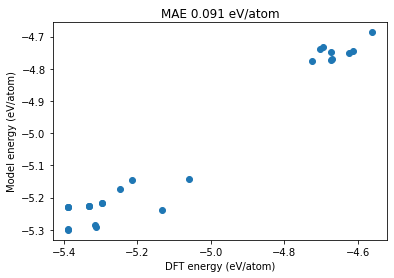

In [32]:
def mae(x, y):
    return np.mean(np.abs(np.array(x).ravel() - np.array(y).ravel()))
plt.plot(test_energy_per_atom, test_energy_per_atom_pred, 'o')

plt.title(f"MAE {mae(test_energy_per_atom, test_energy_per_atom_pred):.3f} eV/atom")
plt.xlabel("DFT energy (eV/atom)")
plt.ylabel("Model energy (eV/atom)")

Text(0.5, 1.0, 'Force MAE 0.189 eV/$\\AA$')

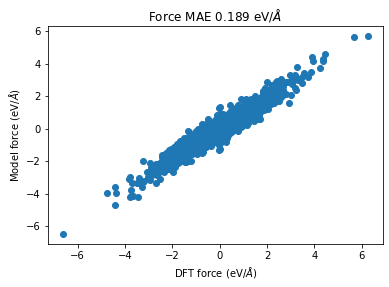

In [30]:
plt.plot(test_forces.ravel(), test_forces_pred.ravel(), 'o')
plt.xlabel("DFT force (eV/$\AA$)")
plt.ylabel("Model force (eV/$\AA$)")
plt.title(f"Force MAE {mae(test_forces, test_forces_pred):.3f} eV/$\AA$")

Using rough parameter set and small number of training steps, the M3GNet potential model can already achieve reasonable results.

In practice, to get better results, more EPOCHS are generally needed. One may also need to increase number of units and number of convolutional blocks.

### M3GNet molecular ML potential training

Here we will use the ethanol data set from MD17 as an example.

In [10]:
KCALMOL_EV = 23.06035
molecules, energies, forces = load_data("ethanol_MD17.json")

n_total = len(molecules)
indices = np.array(range(n_total))
np.random.shuffle(indices)


# We will use 1000 data points as train and validation
train_indices = indices[:950]
val_indices = indices[950:1000]

# The rest will be used as test set

test_indices = indices[1000:]

def get_subset(inds):
    return [molecules[i] for i in inds], np.array(energies)[inds] / KCALMOL_EV, [forces[i]/KCALMOL_EV for i in inds]

train_mols, train_energies, train_forces = get_subset(train_indices)
val_mols, val_energies, val_forces = get_subset(val_indices)
test_mols, test_energies, test_forces = get_subset(test_indices)


Model training will be identical to the previous example using crystals

In [11]:
potential = Potential(M3GNet(n_blocks=1, is_intensive=False))

trainer = PotentialTrainer(potential=potential,
                          optimizer=tf.keras.optimizers.Adam(1e-3))

In [12]:
trainer.train(graphs_or_structures=train_mols,
             energies=train_energies,
             forces=train_forces,
             validation_graphs_or_structures=val_mols,
             val_energies=val_energies,
             val_forces=val_forces,
             batch_size=4,
             force_loss_ratio=1.0,
             epochs=10,
             fit_per_element_offset=True)

Epoch 1/10
238/238 [==============================] - 57s 193ms/step - loss: 1.2171 - MAE(E): 0.0211 - MAE(F): 0.7982 - MAE(S): 0.0000e+00 - val_MAE: 0.5207 - val_MAE(E): 0.0224 - val_MAE(F): 0.4983 - val_MAE(S): 0.0000e+00
Epoch 2/10
238/238 [==============================] - 6s 27ms/step - loss: 0.4629 - MAE(E): 0.0189 - MAE(F): 0.4772 - MAE(S): 0.0000e+00 - val_MAE: 0.3488 - val_MAE(E): 0.0180 - val_MAE(F): 0.3308 - val_MAE(S): 0.0000e+00
Epoch 3/10
238/238 [==============================] - 6s 26ms/step - loss: 0.1671 - MAE(E): 0.0236 - MAE(F): 0.3054 - MAE(S): 0.0000e+00 - val_MAE: 0.2998 - val_MAE(E): 0.0282 - val_MAE(F): 0.2716 - val_MAE(S): 0.0000e+00
Epoch 4/10
238/238 [==============================] - 6s 26ms/step - loss: 0.1256 - MAE(E): 0.0220 - MAE(F): 0.2604 - MAE(S): 0.0000e+00 - val_MAE: 0.2522 - val_MAE(E): 0.0160 - val_MAE(F): 0.2362 - val_MAE(S): 0.0000e+00
Epoch 5/10
238/238 [==============================] - 6s 26ms/step - loss: 0.1037 - MAE(E): 0.0271 - MAE(F): 0

Using almost exact training steps, we can train a molecular potential.